In [ ]:
import numpy as np
import pandas as pd



from scipy import stats
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# from sklearn.model_selection import cross_val_score
# from scipy import stats
# from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# from sklearn.impute import SimpleImputer
# from numpy import where
# from sklearn.datasets import make_classification
# from matplotlib import pyplot

# from numpy import unique
# from numpy import where
# from sklearn.cluster import DBSCAN
# from matplotlib import pyplot

# from scipy.fftpack import fft
# import matplotlib.pyplot as plt

# from sklearn import datasets
# from sklearn.model_selection import train_test_split
# from sklearn import preprocessing

# from sklearn.model_selection import GridSearchCV

# from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
# from numpy import unique

# from sklearn.decomposition import PCA

# from sklearn.feature_selection import VarianceThreshold

# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import chi2

# from sklearn.feature_selection import SequentialFeatureSelector

## Validação Cruzada PRIMEIRA ETAPA DO TRABALHO

https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html 
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html 
https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB 
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier 
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier

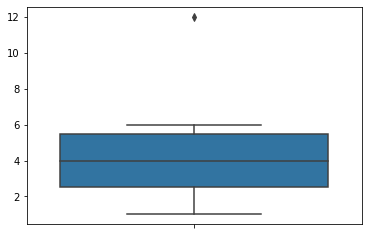

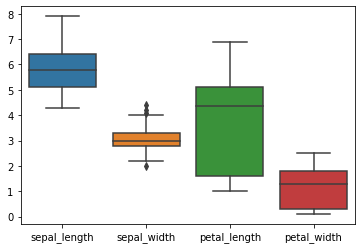

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
# Apêndice A. Boxplots usando seaborn 
def example1():
    mydata=[1,2,3,4,5,6,12]
    sns.boxplot(y=mydata) # Also accepts numpy arrays
    plt.show()
def example2():
    df = sns.load_dataset('iris')
    #returns a DataFrame object. This dataset has 150 examples.
    #print(df)
    # Make boxplot for each group
    sns.boxplot( data=df.loc[:,:] )
    # loc[:,:] means all lines and all columns
    plt.show()
example1()
example2()

In [1]:
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import cross_val_score#, RepeatedStratifiedKFold
# from sklearn.model_selection import cross_val_score
# from scipy import stats
# from sklearn.metrics import confusion_matrix, plot_confusion_matrix


# oneNN = KNeighborsClassifier(n_neighbors=1)
# scores = cross_val_score(oneNN, iris_X, iris_y, cv=10)

# print('fold accuracy:', scores)

# mean = scores.mean()
# std = scores.std()
# inf, sup = stats.norm.interval(0.95, loc=mean, 
#                                scale=std/np.sqrt(len(scores)))

# print("MÉDIA E INTERVALO DE CONFIANÇA É OQ TEM Q SER MOSTRADO NO TRABALHO:")
# print("\nMean Accuracy: %0.2f Standard Deviation: %0.2f" % (mean, std))
# print ("Accuracy Confidence Interval (95%%): (%0.2f, %0.2f)\n" % (inf, sup))  
# from sklearn.model_selection import cross_val_predict

# y_pred = cross_val_predict(oneNN, iris_X, iris_y, cv=5)
# conf_mat = confusion_matrix(iris_y, y_pred)

# print(conf_mat)



# plt.matshow(conf_mat)
# for i in range(len(conf_mat)):
#     for j in range(len(conf_mat)):
#         plt.text(i, j, conf_mat[i][j], va="center", ha="center")

# plt.show()



In [2]:
import pandas as pd
df_cmap = pd.DataFrame(conf_mat, index = range(len(conf_mat)), columns = range(len(conf_mat)) )
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cmap, cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True), annot=True) # font size
plt.tick_params(axis='both', which='major', labelsize=14, labelbottom = False, left=True, top = True, labeltop=True)
plt.show()

NameError: name 'conf_mat' is not defined

## Etapa 1
### Classificadores que não possuem hiperparâmetros

In [3]:
from sklearn import datasets
import numpy as np
iris = datasets.load_iris()
iris_X = iris.data
iris_y = iris.target
wine = datasets.load_wine()
wine_X, wine_y = wine.data, wine.target


cncer = datasets.load_breast_cancer()
cncer_X, cncer_y = cncer.data, cncer.target

print(wine_X)


print(np.shape(wine_X), np.unique(wine_y))
print(np.shape(cncer_X), np.unique(cncer_y))

print(type(iris))
print(type(iris_X))
print(type(iris_y))

labels = np.unique(iris_y)
print (labels)
print (iris.data.shape, iris.target.shape)

print(iris_X)
print(iris_y)

[[1.423e+01 1.710e+00 2.430e+00 ... 1.040e+00 3.920e+00 1.065e+03]
 [1.320e+01 1.780e+00 2.140e+00 ... 1.050e+00 3.400e+00 1.050e+03]
 [1.316e+01 2.360e+00 2.670e+00 ... 1.030e+00 3.170e+00 1.185e+03]
 ...
 [1.327e+01 4.280e+00 2.260e+00 ... 5.900e-01 1.560e+00 8.350e+02]
 [1.317e+01 2.590e+00 2.370e+00 ... 6.000e-01 1.620e+00 8.400e+02]
 [1.413e+01 4.100e+00 2.740e+00 ... 6.100e-01 1.600e+00 5.600e+02]]
(178, 13) [0 1 2]
(569, 30) [0 1]
<class 'sklearn.utils.Bunch'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[0 1 2]
(150, 4) (150,)
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0.2]
 [5.7 4.4 1.5 0.4]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.7 3.8 1.7 0.3]
 [5.1 3.8 1.5 0.3]
 [5.4 3.4 1.7 0.2]
 [5.1 3.7 1.5 0.4]
 [4.6 3.6 1.  0.2]
 [5.1 3.3 1.7 0.5]


In [4]:
import warnings
import numpy as np
from scipy.stats import norm

# retorna um dict contendo media, variancia e limites inf & sup de uma lista de scores
def get_score_stts(scores):
    r = {}
    r["mean"], r["std"] = scores.mean(), scores.std()

    scale = r["std"]/np.sqrt(len(scores))
    with warnings.catch_warnings():
        if r["std"] == 0.0:
            warnings.simplefilter('ignore') #Ignora warning que são causados quando a variância = 0
        r["inf"], r["sup"] = np.nan_to_num(norm.interval(0.95, loc=r["mean"], scale=scale), nan=r["mean"])
        
    return r


In [5]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Plota a matrix de confusão usando Heatmap do seaborn
def plot_conf_mat(conf_mat):
    df_cmap = pd.DataFrame(conf_mat, index = range(len(conf_mat)), columns = range(len(conf_mat)) )
    sns.set(font_scale=1.4) # for label size
    sns.heatmap(df_cmap, cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True), annot=True) # font size
    plt.tick_params(axis='both', which='major', labelsize=14, labelbottom = False, left=True, top = True, labeltop=True)


In [6]:
rand_state = 36851234

In [33]:
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
# from sklearn.neighbors import KNeighborsClassifier


from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix#, plot_confusion_matrix
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_predict



classifiers = {
    "ZeroR": DummyClassifier(strategy="most_frequent", random_state=rand_state),
    "Aleatorio": DummyClassifier(strategy="uniform", random_state=rand_state),
    "Aleatorio_Estrat": DummyClassifier(strategy="stratified", random_state=rand_state),
    # "OneR_Probab": {}, #Falta implementar
    "Naive_Bayes": GaussianNB()
}

# Dicionario que guardará os dados gerados de cada scores
results = dict.fromkeys(["ZeroR", "Aleatorio", "Aleatorio_Estrat", "Naive_Bayes"])

conf_mats = []

for key, classifier in classifiers.items(): 
    rkf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=rand_state)
    scores = cross_val_score(classifier, cncer_X, cncer_y, cv=rkf, scoring="accuracy")
    

    results[key] = get_score_stts(scores)

    y_pred = cross_val_predict(classifier, iris_X, iris_y, cv=10)
    conf_mats.append(confusion_matrix(iris_y, y_pred))

    print(key,'\n', conf_mats[-1])

results_df = pd.DataFrame(results).T
print(results_df)

ZeroR 
 [[50  0  0]
 [50  0  0]
 [50  0  0]]
Aleatorio 
 [[ 0 30 20]
 [10 30 10]
 [30 10 10]]
Aleatorio_Estrat 
 [[20  0 30]
 [10 30 10]
 [20 10 20]]
Naive_Bayes 
 [[50  0  0]
 [ 0 47  3]
 [ 0  4 46]]
                      mean       std       inf       sup
ZeroR             0.627412  0.006966  0.624920  0.629905
Aleatorio         0.467972  0.061841  0.445843  0.490101
Aleatorio_Estrat  0.528958  0.056950  0.508579  0.549337
Naive_Bayes       0.939630  0.025589  0.930473  0.948787


### I/O: Saves plots and Write latex table in a txt file

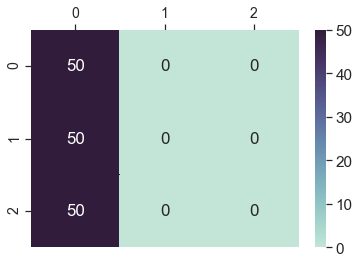

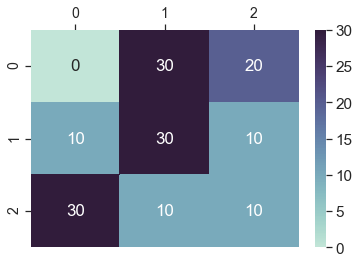

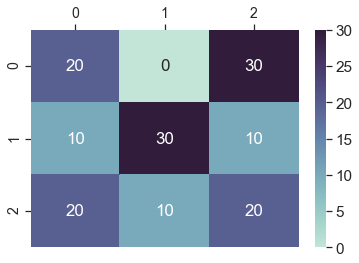

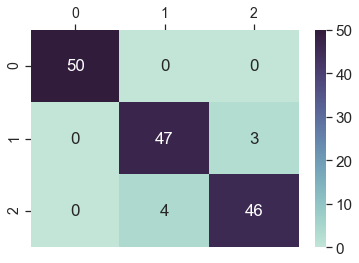

In [8]:
from pathlib import Path


# Salvar Plots no diretorio /plots
Path("plots/").mkdir(parents=True, exist_ok=True)
for c_mat in conf_mats:
    plot_conf_mat(c_mat)
    plt.savefig('plots/'+key+'_confusion_matrix.png', dpi=200)
    plt.show()

# Salvar tabela latex no diretorio /latex_tables
Path("latex_tables/").mkdir(parents=True, exist_ok=True)
with open('latex_tables/result_table.txt', 'w') as file:
    file.write(results_df.to_latex(float_format="%.2f"))

## Implementação do genetic Algorithm para o Kcentroids

In [58]:
import random as rand
import numpy as np
from scipy.spatial.distance import cdist

# Utils
def evaluate_dists_state(min_dists):
    '''
        Return: SSE baseado na array de distancias
    '''
    return np.sum(min_dists)

def get_diff_obs_state(current_label, k):
    '''
        Retorna uma label diferente da label atual entre as k disponiveis
    '''
    new_label = rand.randint(0, k-1)
    while new_label == current_label:
        new_label = rand.randint(0, k-1)
    return new_label


class Clustering:
    '''Lida com a instãncia de um problema de clusterização.
    '''
    def __init__(self, data, rand_state = None):
        '''valores do problema:
                data: ndarray size M x N
                    Cada linha da array é uma observação.
                    As colunas são os atributos de cada observação
                num_obs: int
                    Número de observações no dataset
                num_feat: int
                    numero de features (atributos) no dataset
        '''
        rand.seed(rand_state)
        self.data = data
        self.num_obs = len(data)
        self.num_feat = len(data[0])

    def generate_initial_centroids(self, k):
        '''
            Seleciona aleatoriamente K linhas para serem os centroides
        '''
        points = np.random.choice(self.num_obs, size=k, replace=False)
        # print("points:", points. "\n")
        points = self.data[points].copy()
        # print("selected centroids:", points, "\n")
        return points

    def get_centroid(self):
        centroid = np.sum(self.data, axis=0)
        return (centroid / self.num_obs).tolist()

    def update_centroids(self, labels, k):
        """ Parameters:
                labels : int ndarray
                    array of the labels of the observations.
                k : int
                    The number of centroids (codes).
            Returns:
                centroids: k x n ndarray
                new centroids matrix
                has_members : ndarray
                    A boolean array indicating which clusters have members.
        """
        centroids = np.zeros((k, self.num_feat), dtype=self.data.dtype)

        # sum of the numbers of obs in each cluster
        obs_count = np.zeros(k, np.int)

        for i in range(self.num_obs):
            label = labels[i]
            obs_count[label] += 1
            centroids[label] += self.data[i]

        for i in range(k):
            cluster_size = obs_count[i]

            if cluster_size > 0:
                # Calculate the centroid of each cluster
                centroids[i] = centroids[i] / cluster_size

        # Return a boolean array indicating which clusters have members
        return centroids, obs_count > 0

    def update_centroids_safe(self, centroids, labels, k):
        """ Atualiza o estado da lista de centroides com base nas labels
            Difere da função update_centroids por corrigir internamente
            problemas de cluster sem membros
        """
        new_centroids, has_members = self.update_centroids(labels, k)
        # Caso algum centroide novo não possua membros, atribui a posicao anterior
        if not has_members.all():
            # Setting to previous centroid position
            new_centroids[~has_members] = centroids[~has_members]
        return new_centroids

    def assign_clusters(self, centroids):
        ''' Parametros:
                centroids: ndarray size k x N
                    Cada linha é um centroide
            Retornos:
                labels: ndarray size M
                    Uma array contendo o index do cluster atribuido a cada observacao
                min_dists: ndarray size M
                    Array contendo a distancia da i-ésima observação até o centroide mais proximo
        '''
        dists = cdist(self.data, centroids, 'sqeuclidean')
        labels = dists.argmin(axis=1)
        min_dists = dists[np.arange(len(labels)), labels]
        return labels, min_dists

    # GENTIC ALGORITHN
    def evaluate(self, state):
        """Retorna o sse de um centroide (state)"""
        min_dists = self.assign_clusters(state)[1]
        return evaluate_dists_state(min_dists)

    def gerar_populacao(self, populacao, t_pop, k):
        """Preenche uma população a partir do primeiro individuo da população dada
        """
        state = populacao[0]
        labels = self.assign_clusters(state)[0]

        while len(populacao) < t_pop:
            new_labels = labels.copy()
            rand_obs = rand.randrange(0, self.num_obs)

            new_labels[rand_obs] = get_diff_obs_state(labels[rand_obs], k)
            new_state, has_members = self.update_centroids(new_labels,k)

            if has_members.all():
                populacao.append(new_state)

    def selecao(self, states):
        """ função de selecao por roleta (mantendo um unico sobrevivente na população)
                1º: calcula as probabilidades de cada um sobreviver
                2º: calcula a faixa de sobrevivência
                3º: Roda a roleta
        """
        total = sum(list(map(self.evaluate, states)))
        percents = list(map(lambda s: (s, self.evaluate(s)/total),states))

        prob_ranges = list()
        low_bound = 0
        for s in percents:
            prob_ranges.append((s[0], low_bound, low_bound + s[1]))
            low_bound += s[1]

        n = rand.random()
        # n = rand.uniform(0,1)
        for prob in prob_ranges:
            if n >= prob[1] and n <= prob[2]:
                states.clear()
                states.append(prob[0])

    def mutacao(self, state):
        labels = self.assign_clusters(state)[0]
        k = len(state)

        # define aleatoriamente quantas mutacoes acontecerao nas labels (até 10)
        for _ in range(rand.randint(1,10)):
            rand_obs = rand.randrange(0, self.num_obs)
            labels[rand_obs] = get_diff_obs_state(labels[rand_obs], k)

        new_state = self.update_centroids_safe(state, labels, k)

        return new_state

    def melhor_da_geracao(self, states):
        num_pop = len(states)

        melhor = states[0].copy()
        melhor_sse = self.evaluate(states[0])

        for i in range(1, num_pop):
            sse = self.evaluate(states[i])
            if sse < melhor_sse:
                melhor = states[i].copy()
                melhor_sse = sse

        return melhor, melhor_sse

""" Metodo Algoritmo Genético
        Hiperparametros : 
            max_iter : número máximo de iterações (critério de parada)
            t_pop : tamanho da população
            taxa_cross : chance de ocorrer crossover
            taxa_mutacao : chance de ocorrer mutação

        Tipo : Baseada em Soluções Completas -> Busca Populacional -> Computação Evolutiva
"""
import time
import random as rand
import numpy as np

def ocorre(p):
    """Retorna se um evento com chance p ocorre ou não
    """
    n = rand.random()
    return  n <= p

def crossover(state1, state2):
    num_feat = len(state1)
    # Quantidade aleatoria de crossovers
    qtd = rand.randint(0, num_feat)

    for _ in range(qtd):
        gene = rand.randrange(num_feat)
        aux = state1[gene]
        state1[gene] = state2[gene]
        state2[gene] = aux


def genetic(problem: Clustering, k, t_pop, taxa_cross, taxa_mutacao, t = 1., max_sem_melhora = 20, max_iter = 3000, rand_state=None):
    """ Parametros : 
            problem : uma instancia do problema de clustering
            k : quantidade de centroides
            t_pop : tamanho da população
            taxa_cross : chance de ocorrer crossover
            taxa_mutacao : chance de ocorrer mutação
            max_sem_melhora : quantidade maxima de iteracoes sem melhora (critério de parada)
            max_iter : número máximo de iterações (critério de parada)
            t : tempo
    """
    rand.seed(rand_state)
    start = time.process_time()
    end = 0
    if k == 1:
        return [problem.get_centroid()], time.process_time()-start, 1

    melhor = problem.generate_initial_centroids(k)
    populacao = [melhor]

    melhor_sse = np.inf
    qtd_geracoes_sem_melhora = 0

    i = 0

    while i < max_iter and qtd_geracoes_sem_melhora < max_sem_melhora and end-start < t:
        # Seleciona um estado com potencial e gera a população
        problem.selecao(populacao)
        problem.gerar_populacao(populacao, t_pop, k)

        # Realiza um numero aleatorio de crossovers e mutacoes, 
        # entre metade do tamanho e o tamanho da populacao
        for _ in range(1, rand.randrange(t_pop//2,t_pop)):
            if end-start < t:
                break
            # Crossover
            if ocorre(taxa_cross):
                x = rand.randrange(len(populacao))
                y = rand.randrange(len(populacao))
                while x == y:
                    y = rand.randrange(len(populacao))
                crossover(populacao[x], populacao[y])
            # Mutacao
            if ocorre(taxa_mutacao):
                x = rand.randrange(len(populacao))
                populacao[x] = problem.mutacao(populacao[x])
                
            end = time.process_time()

        melhor_da_geracao, melhor_sse_geracao = problem.melhor_da_geracao(populacao)

        if melhor_sse_geracao < melhor_sse:
            melhor = melhor_da_geracao
            melhor_sse = melhor_sse_geracao
            qtd_geracoes_sem_melhora = 0
        else:
            qtd_geracoes_sem_melhora += 1

        i += 1
        end = time.process_time()

    return melhor, end-start, i

### KGAcentroides

In [64]:
def kga(data, k, rand_state=None):
    problem = Clustering(data, rand_state)
    centroids, _, _ =  genetic(problem, k, t_pop=10, taxa_cross=0.95, taxa_mutacao=0.2, t = 2., max_sem_melhora = 20, max_iter = 3000, rand_state=rand_state)
    return centroids

In [56]:
from sklearn.cluster import KMeans

def kmeans(data, k, rand_state=None):
    km = KMeans(n_clusters=k, random_state=rand_state)
    km.fit(data)
    return km.cluster_centers_

In [104]:
from collections import Counter
import numpy as np
from scipy.spatial.distance import cdist

from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_X_y



class Kcentroides(BaseEstimator):
    def __init__(self, method=None, k=5, random_state=None):
        super().__init__()
        self.k = k
        self.method = method
        self.random_state = random_state
    
    def fit(self,x_train,y_train):
        x_train,y_train = check_X_y(x_train,y_train)
        clss_names = np.unique(y_train)
        mapp = { k: i for i, k in  enumerate(clss_names)}
        

        # Faz uma lista de classes, mapeando as classes em indices
        x_classes = [[] for i in range(len(clss_names))]
        for observation, clss in zip(x_train, y_train):
            x_classes[mapp[clss]].append(observation)
        
        
        # gera os k centroids de cada classe
        c_classes = [[] for i in range(len(clss_names))]
        for clss, x_clss in enumerate(x_classes):
            c_classes[clss] = self.method(np.array(x_clss), self.k, self.random_state)

        self.__c_classes = np.asarray(c_classes)
        self.__clss_names = clss_names

    def predict(self,x_test):
        dist_array = [ np.min(cdist(x_test, c_clss, 'sqeuclidean'),axis=1) for c_clss in self.__c_classes]
        return self.__clss_names[np.argmin(dist_array, axis=0)]

In [357]:
import pandas as pd
import itertools
import random as rand

def run_roulettes(roulettes, random_state = None):
    rand.seed(random_state)
    results = []
    for attr in roulettes:
        chosen = rand.random()
        for i, odd in enumerate(attr):
            if chosen <= odd:
                results.append(i)
                break
    return results

class OneRProbabilistico(BaseEstimator):
    def __init__(self, random_state=None):
        super().__init__()
        self.random_state = random_state

    def fit(self, x_train, y_train):
        x_train, y_train = check_X_y(x_train, y_train)

        # Contingency Table for each attribute in x
        contin_table = [pd.crosstab(attribute, y_train) for attribute in x_train.T ]
        # index and table of the best Attribute for differentiation
        self.i_best_attr = np.argmax([table.max(axis=1).sum() for table in contin_table])
        best_attr = contin_table[self.i_best_attr]
        # class distribution
        self.class_dist = best_attr.div(best_attr.sum(axis=1), axis=0)

    def predict(self, X):
        attr_values = X.T[self.i_best_attr]
        attr_chances = self.class_dist.loc[attr_values].values

        # Build Roulette list: [0.1, 0.5, 0.4] => [0.1, 0.6, 1.0]
        roulettes = attr_chances.copy()
        for attr in roulettes:
            for a, b, i in zip(attr, attr[1:], range(1,len(attr))): attr[i] = a + b
        
        # Run roulette
        predicted_results = run_roulettes(roulettes, self.random_state)

        return predicted_results

In [350]:
x, y  = datasets["Iris"].data, datasets["Iris"].target
discretizer = KBinsDiscretizer(n_bins=2*len(np.unique(y)), encode = 'ordinal', strategy = 'kmeans')

x_disc = discretizer.fit_transform(x)

contin_table = [pd.crosstab(prop, y) for prop in x_disc.T][3]

class_dist = contin_table.div(contin_table.sum(axis=1), axis=0)

print(class_dist)

clss_names = class_dist.columns

attr_values = x_disc.T[3]

attr_chances = class_dist.loc[attr_values].values

roulettes = attr_chances.copy()
for attr in roulettes:
    for a, b, i in zip(attr, attr[1:], range(1,len(attr))): attr[i] = a + b

results = []
for attr in roulettes:
    chosen = rand.random()
    for i, odd in enumerate(attr):
        if chosen <= odd:
            results.append(i)
            break
for x in zip(roulettes, results):
    print(x)

# a = np.argmax([table.max(axis=1).sum() for table in contin_table])

# print(a)

col_0    0         1         2
row_0                         
0.0    1.0  0.000000  0.000000
1.0    1.0  0.000000  0.000000
2.0    0.0  1.000000  0.000000
3.0    0.0  0.833333  0.166667
4.0    0.0  0.080000  0.920000
5.0    0.0  0.000000  1.000000
(array([1., 1., 1.]), 0)
(array([1., 1., 1.]), 0)
(array([1., 1., 1.]), 0)
(array([1., 1., 1.]), 0)
(array([1., 1., 1.]), 0)
(array([1., 1., 1.]), 0)
(array([1., 1., 1.]), 0)
(array([1., 1., 1.]), 0)
(array([1., 1., 1.]), 0)
(array([1., 1., 1.]), 0)
(array([1., 1., 1.]), 0)
(array([1., 1., 1.]), 0)
(array([1., 1., 1.]), 0)
(array([1., 1., 1.]), 0)
(array([1., 1., 1.]), 0)
(array([1., 1., 1.]), 0)
(array([1., 1., 1.]), 0)
(array([1., 1., 1.]), 0)
(array([1., 1., 1.]), 0)
(array([1., 1., 1.]), 0)
(array([1., 1., 1.]), 0)
(array([1., 1., 1.]), 0)
(array([1., 1., 1.]), 0)
(array([1., 1., 1.]), 0)
(array([1., 1., 1.]), 0)
(array([1., 1., 1.]), 0)
(array([1., 1., 1.]), 0)
(array([1., 1., 1.]), 0)
(array([1., 1., 1.]), 0)
(array([1., 1., 1.]), 0)
(a

In [374]:
import time

# from sklearn.model_selection import cross_val_predict #Para heatmap
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer

def phase_one(dataset, method, needs_discretizer=False, rand_state=None):
    start = time.process_time()
    x, y = dataset.data, dataset.target

    rkf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=rand_state)

    pipe_list = [('transformer', StandardScaler()), ('estimator', method)]
    if needs_discretizer: 
        discretizer = KBinsDiscretizer(n_bins=2*len(np.unique(y)), encode = 'ordinal', strategy = 'kmeans')
        pipe_list.insert(1, ('discretizer', discretizer))

    pipeline = Pipeline(pipe_list)

    scores = cross_val_score(pipeline, x, y, cv=rkf, scoring="accuracy")
    status = get_score_stts(scores)

    return {"scores": scores, "status": status, "time": time.process_time()-start}


In [383]:
phase_one(datasets["Iris"], OneRProbabilistico(rand_state), True, rand_state)

{'scores': array([1.        , 0.8       , 1.        , 0.86666667, 0.86666667,
        0.86666667, 1.        , 0.93333333, 0.86666667, 0.8       ,
        1.        , 0.93333333, 0.8       , 0.86666667, 0.8       ,
        1.        , 0.93333333, 0.93333333, 0.93333333, 0.93333333,
        0.93333333, 1.        , 0.86666667, 0.8       , 0.73333333,
        1.        , 0.93333333, 0.93333333, 1.        , 0.93333333]),
 'status': {'mean': 0.908888888888889,
  'std': 0.07597920443235004,
  'inf': 0.8817005793659591,
  'sup': 0.9360771984118188},
 'time': 1.4256569999997737}

In [376]:
import time
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, RepeatedStratifiedKFold, cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler

def phase_two(dataset, method, grid, rand_state=None):
    start = time.process_time()
    x, y = dataset.data, dataset.target

    pipeline = Pipeline([('transformer', StandardScaler()), ('estimator', method)])

    inner = StratifiedKFold(n_splits=4,random_state=rand_state, shuffle=True)
    inner_gs = GridSearchCV(estimator=pipeline, param_grid = grid, scoring='accuracy', cv = inner)
        
    outter = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=rand_state)

    scores = cross_val_score(inner_gs, x, y, scoring='accuracy', cv = outter)
    status = get_score_stts(scores)

    return {"scores": scores, "status": status, "time": time.process_time()-start}

In [384]:
from sklearn import datasets

# Classificadores
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

rand_state = 36851234

datasets = {
    'Iris': datasets.load_iris(),
    'Digits': datasets.load_digits(),
    'Wine': datasets.load_wine(),
    'Breast Cancer': datasets.load_breast_cancer()
}

classifs = {
    "call": {
        "ZeroR": DummyClassifier(strategy="most_frequent", random_state=rand_state),
        "Aleatorio": DummyClassifier(strategy="uniform", random_state=rand_state),
        "Estratificado": DummyClassifier(strategy="stratified", random_state=rand_state),
        "OneR Probab": OneRProbabilistico(random_state=rand_state), 
        "Naive Bayes": GaussianNB(),
        "KMeans": Kcentroides(method=kmeans, random_state=rand_state),
        "KGA": Kcentroides(method=kga, random_state=rand_state),
        "KNN": KNeighborsClassifier(weights='uniform'), 
        "DistKNN": KNeighborsClassifier(weights='distance'),
        "Árvore Desc": DecisionTreeClassifier(random_state=rand_state),
        "Floresta": RandomForestClassifier(random_state=rand_state)
    },
    "p_grid": {
        "KMeans": {'estimator__k': [1,3,5,7]},
        "KGA": {'estimator__k': [1,3,5,7]},
        "KNN": {'estimator__n_neighbors': [1,3,5,7]}, 
        "DistKNN": {'estimator__n_neighbors': [1,3,5,7]},
        "Árvore Desc": {'estimator__max_depth': [None, 3, 5,10]},
        "Floresta": {'estimator__n_estimators': [10,20,50,100]}
    },
    "needs_discrete": ["OneR Probab"]
}

# Initializing results dict
results = {k: dict(dict.fromkeys(classifs["call"])) for k in  datasets}

# Processando
for dataset, ds_data in datasets.items():
    for method, call in classifs["call"].items():
        if method not in classifs["p_grid"]:
            results[dataset][method] = phase_one(ds_data, call, method in classifs["needs_discrete"], rand_state)
        else:
            results[dataset][method] = phase_two(ds_data, call, classifs["p_grid"][method], rand_state)
        print(dataset, method, results[dataset][method]["status"], round(results[dataset][method]["time"], 2))

Iris ZeroR {'mean': 0.3333333333333334, 'std': 1.1102230246251565e-16, 'inf': 0.33333333333333337, 'sup': 0.3333333333333335} 0.05
Iris Aleatorio {'mean': 0.26666666666666666, 'std': 0.0, 'inf': 0.26666666666666666, 'sup': 0.26666666666666666} 0.05
Iris Estratificado {'mean': 0.4666666666666667, 'std': 0.0, 'inf': 0.4666666666666667, 'sup': 0.4666666666666667} 0.06
Iris OneR Probab {'mean': 0.908888888888889, 'std': 0.07597920443235004, 'inf': 0.8817005793659591, 'sup': 0.9360771984118188} 1.53
Iris Naive Bayes {'mean': 0.9511111111111111, 'std': 0.051448164012401, 'inf': 0.9327009603599136, 'sup': 0.9695212618623087} 0.07
Iris KMeans {'mean': 0.9533333333333334, 'std': 0.042687494916218975, 'inf': 0.9380580901505224, 'sup': 0.9686085765161443} 24.26
Iris KGA {'mean': 0.9422222222222222, 'std': 0.06378977819736588, 'inf': 0.9193957627062735, 'sup': 0.9650486817381708} 90.5
Iris KNN {'mean': 0.9422222222222222, 'std': 0.0704132423011327, 'inf': 0.9170256300691574, 'sup': 0.9674188143752

                   mean           std       inf       sup
ZeroR          0.333333  1.110223e-16  0.333333  0.333333
Aleatorio      0.266667  0.000000e+00  0.266667  0.266667
Estratificado  0.466667  0.000000e+00  0.466667  0.466667
OneR Probab    0.908889  7.597920e-02  0.881701  0.936077
Naive Bayes    0.951111  5.144816e-02  0.932701  0.969521
KMeans         0.953333  4.268749e-02  0.938058  0.968609
KGA            0.942222  6.378978e-02  0.919396  0.965049
KNN            0.942222  7.041324e-02  0.917026  0.967419
DistKNN        0.946667  5.811865e-02  0.925870  0.967464
Árvore Desc    0.951111  4.532462e-02  0.934892  0.967330
Floresta       0.948889  5.072317e-02  0.930738  0.967040
                   mean       std       inf       sup
ZeroR          0.101285  0.002436  0.100413  0.102157
Aleatorio      0.100901  0.018617  0.094239  0.107563
Estratificado  0.115556  0.023894  0.107005  0.124106
OneR Probab    0.178276  0.023351  0.169921  0.186632
Naive Bayes    0.784305  0.030236 

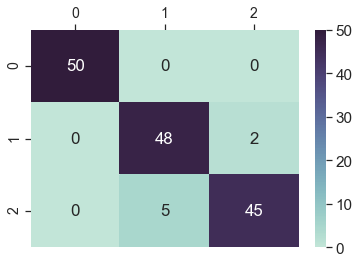

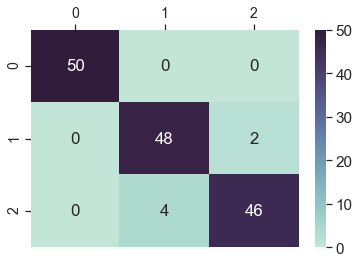

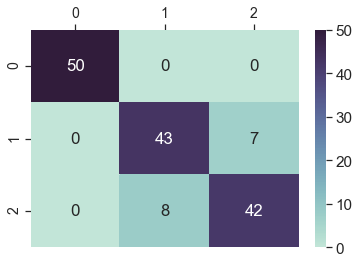

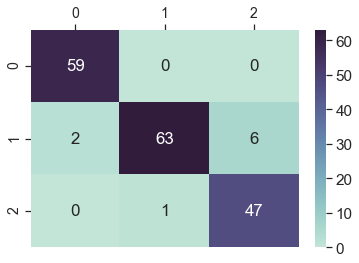

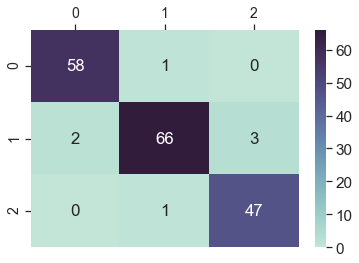

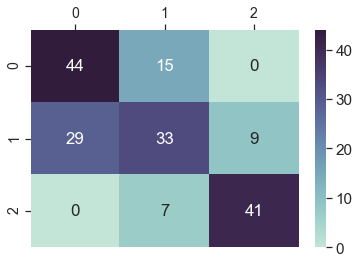

In [391]:
from pathlib import Path
import pandas as pd 
import copy

for ds_name, ds_data in results.items():
    results_df = pd.DataFrame({method: v["status"] for method, v in ds_data.items()}).T
    print(results_df)
    # Salvar tabela latex no subdiretorio /tables
    Path("tables/").mkdir(parents=True, exist_ok=True)
    with open('tables/[LATEX]'+ ds_name.replace(" ", "_") + 'result_table.txt', 'w') as file:
        file.write(results_df.to_latex(float_format="%.2f"))
    with open('tables/[CSV]'+ ds_name.replace(" ", "_") + 'result_table.csv', 'w') as file:
        file.write(results_df.to_csv(float_format="%.2f"))


from sklearn.metrics import confusion_matrix
# Salvar Plots MAtrizes de Confusão no diretorio /plots
for ds_name in ["Iris", "Wine"]:
    x, y = datasets[ds_name].data, datasets[ds_name].target
    for m in ["KMeans", "KGA","OneR Probab"]:
        skf = StratifiedKFold(n_splits=10,random_state=rand_state, shuffle=True)

        classifier = copy.deepcopy(classifs["call"][m])
        if hasattr(classifier, "k"):
            classifier.k = 5

        pipe_list = [('transformer', StandardScaler()), ('estimator', classifier)]
        if m == "OneR Probab": 
            discretizer = KBinsDiscretizer(2*len(np.unique(y)), encode='ordinal', strategy='kmeans')
            pipe_list.insert(1, ('discretizer', discretizer))
        pipeline = Pipeline(pipe_list)

        y_pred = cross_val_predict(pipeline, x, y, cv=skf)
        conf_mat = confusion_matrix(y, y_pred)

        plot_conf_mat(conf_mat)

        # Comente as duas linhas abaixo caso não deseje salvvar no computador
        Path("plots/").mkdir(parents=True, exist_ok=True)
        plt.savefig('plots/[HEATMAP]'+ m + '_' + ds_name +'_k5.png', dpi=200)
        plt.show()

In [467]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

def plot_dataset_boxplot(dataset_df, dataset_name, path):
    # boxplot zscores and tempos
    figsize = (8, 5)
    _, ax = plt.subplots(figsize=figsize)
    ax.set(xlabel='Acurácia', ylabel='Classificador')

    # ax.yaxis.set_label_position("right")
    # ax.yaxis.tick_right()
    sns.boxplot(data=dataset_df.T, ax=ax, orient="h", palette="Set3")
    # plt.yticks(rotation=20)
    plt.tight_layout()
    plt.savefig(path + "[BOXPLOT]" + dataset_name + '_scores',dpi=200)


    plt.show()



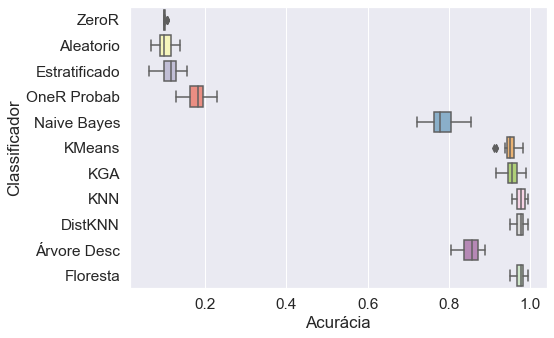

In [468]:
Path("plotss/").mkdir(parents=True, exist_ok=True)
# for ds_name, ds_data in results.items():

score_df = pd.DataFrame({method: v["scores"] for method, v in results["Digits"].items()}).T
plot_dataset_boxplot(score_df, ds_name, "plotss/")


In [465]:
import pprint
for ds_name, ds_data in results.items():
    print(ds_name)
    times = {method: round(v["time"],2) for method, v in ds_data.items()}
    # time_df = pd.DataFrame({method: round(v["time"],2) for method, v in ds_data.items()}).T
    pprint.pprint(times)

Iris
{'Aleatorio': 0.05,
 'DistKNN': 1.2,
 'Estratificado': 0.06,
 'Floresta': 25.86,
 'KGA': 90.5,
 'KMeans': 24.26,
 'KNN': 1.58,
 'Naive Bayes': 0.07,
 'OneR Probab': 1.53,
 'ZeroR': 0.05,
 'Árvore Desc': 1.08}
Digits
{'Aleatorio': 0.09,
 'DistKNN': 9.36,
 'Estratificado': 0.11,
 'Floresta': 66.35,
 'KGA': 1207.68,
 'KMeans': 131.23,
 'KNN': 18.09,
 'Naive Bayes': 0.19,
 'OneR Probab': 224.0,
 'ZeroR': 0.09,
 'Árvore Desc': 6.21}
Wine
{'Aleatorio': 0.06,
 'DistKNN': 1.48,
 'Estratificado': 0.06,
 'Floresta': 28.55,
 'KGA': 118.04,
 'KMeans': 25.51,
 'KNN': 1.86,
 'Naive Bayes': 0.07,
 'OneR Probab': 4.73,
 'ZeroR': 0.06,
 'Árvore Desc': 1.53}
Breast Cancer
{'Aleatorio': 0.07,
 'DistKNN': 3.11,
 'Estratificado': 0.08,
 'Floresta': 41.7,
 'KGA': 350.43,
 'KMeans': 38.58,
 'KNN': 6.14,
 'Naive Bayes': 0.07,
 'OneR Probab': 19.76,
 'ZeroR': 0.07,
 'Árvore Desc': 3.39}


### T-TEST

In [480]:
import scipy.stats as stats

iris_score_df = pd.DataFrame({method: v["scores"] for method, v in results["Iris"].items()}).T
num_methods = iris_score_df.shape[0]
score_values = iris_score_df.values
t_test = np.zeros((num_methods,num_methods))

for i, row in enumerate(score_values):
    for j, row2 in enumerate(score_values):
        t_test[i,j] = stats.ttest_rel(row, row2)[1]
print(t_test)


(0, 0)
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 5)
(0, 6)
(0, 7)
(0, 8)
(0, 9)
(0, 10)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(1, 9)
(1, 10)
(2, 0)
(2, 1)
(2, 2)
(2, 3)
(2, 4)
(2, 5)
(2, 6)
(2, 7)
(2, 8)
(2, 9)
(2, 10)
(3, 0)
(3, 1)
(3, 2)
(3, 3)
(3, 4)
(3, 5)
(3, 6)
(3, 7)
(3, 8)
(3, 9)
(3, 10)
(4, 0)
(4, 1)
(4, 2)
(4, 3)
(4, 4)
(4, 5)
(4, 6)
(4, 7)
(4, 8)
(4, 9)
(4, 10)
(5, 0)
(5, 1)
(5, 2)
(5, 3)
(5, 4)
(5, 5)
(5, 6)
(5, 7)
(5, 8)
(5, 9)
(5, 10)
(6, 0)
(6, 1)
(6, 2)
(6, 3)
(6, 4)
(6, 5)
(6, 6)
(6, 7)
(6, 8)
(6, 9)
(6, 10)
(7, 0)
(7, 1)
(7, 2)
(7, 3)
(7, 4)
(7, 5)
(7, 6)
(7, 7)
(7, 8)
(7, 9)
(7, 10)
(8, 0)
(8, 1)
(8, 2)
(8, 3)
(8, 4)
(8, 5)
(8, 6)
(8, 7)
(8, 8)
(8, 9)
(8, 10)
(9, 0)
(9, 1)
(9, 2)
(9, 3)
(9, 4)
(9, 5)
(9, 6)
(9, 7)
(9, 8)
(9, 9)
(9, 10)
(10, 0)
(10, 1)
(10, 2)
(10, 3)
(10, 4)
(10, 5)
(10, 6)
(10, 7)
(10, 8)
(10, 9)
(10, 10)
